In [1]:
import os 
import warnings
import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train=pd.read_csv('/kaggle/input/network-intrusion-detection/Train_data.csv')
test= pd.read_csv('/kaggle/input/network-intrusion-detection/Test_data.csv')

In [3]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [4]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,tcp,private,REJ,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


In [5]:
print('Training set contains {} records and {} attributes'.format(train.shape[0],train.shape[1]))
print('Test set contains {} records and {} attributes'.format(test.shape[0],test.shape[1]))

Training set contains 25192 records and 42 attributes
Test set contains 22544 records and 41 attributes


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [7]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


***PRE PROCESSING***

In [8]:
print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [9]:
#'num_outbound_cmds' is a redundant column so remove it from both train & test datasets
train.drop(['num_outbound_cmds'] , axis=1, inplace=True)
test.drop(['num_outbound_cmds'] , axis=1, inplace=True)

In [10]:
# Attack Class Distribution
train['class'].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

In [11]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]

if not missing_columns:
    print("No missing values")
else:
    for col in missing_columns:
        null_count = train[col].isnull().sum()
        per = (null_count / total) * 100
        print(f"{col}: {null_count} ({round(per, 3)}%)")

No missing values


In [12]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


<Axes: xlabel='class', ylabel='count'>

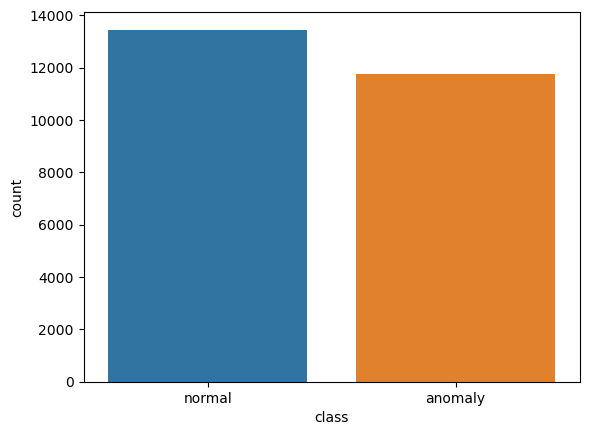

In [13]:
sns.countplot(x=train['class'])

**UNIQUE VALUES**

In [14]:
cat_features = ['protocol_type', 'service', 'flag']
for f in cat_features:
    print(f"=====Unique values of {f}=====\n")
    unique_vals = train[f].unique()
    print(unique_vals)
    print(f"Number of unique values: {len(unique_vals)}\n")

=====Unique values of protocol_type=====

['tcp' 'udp' 'icmp']
Number of unique values: 3

=====Unique values of service=====

['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001']
Number of unique values: 66

=====Unique values of flag=====

['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']
Number of unique values: 11



***EXPLORATORY DATA ANALYSIS***

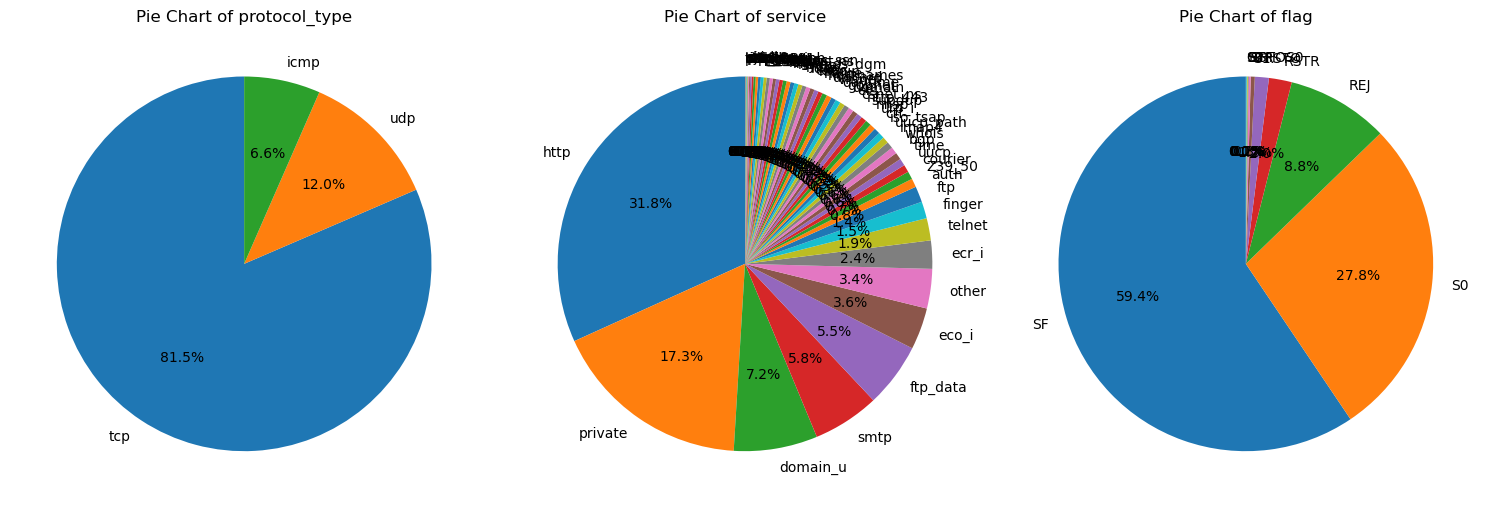

In [15]:
import matplotlib.pyplot as plt

num_cols = 3  # Number of columns in the subplot grid
num_rows = (len(cat_features) + num_cols - 1) // num_cols  # Calculate the number of rows

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the subplot grid for easy iteration
axs = axs.flatten()

# Loop through categorical features
for i, f in enumerate(cat_features):
    ax = axs[i]  # Get the current axis
    val_counts = train[f].value_counts()

    # Create a pie chart
    ax.pie(val_counts, labels=val_counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(f"Pie Chart of {f}")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


<Figure size 1500x1000 with 0 Axes>

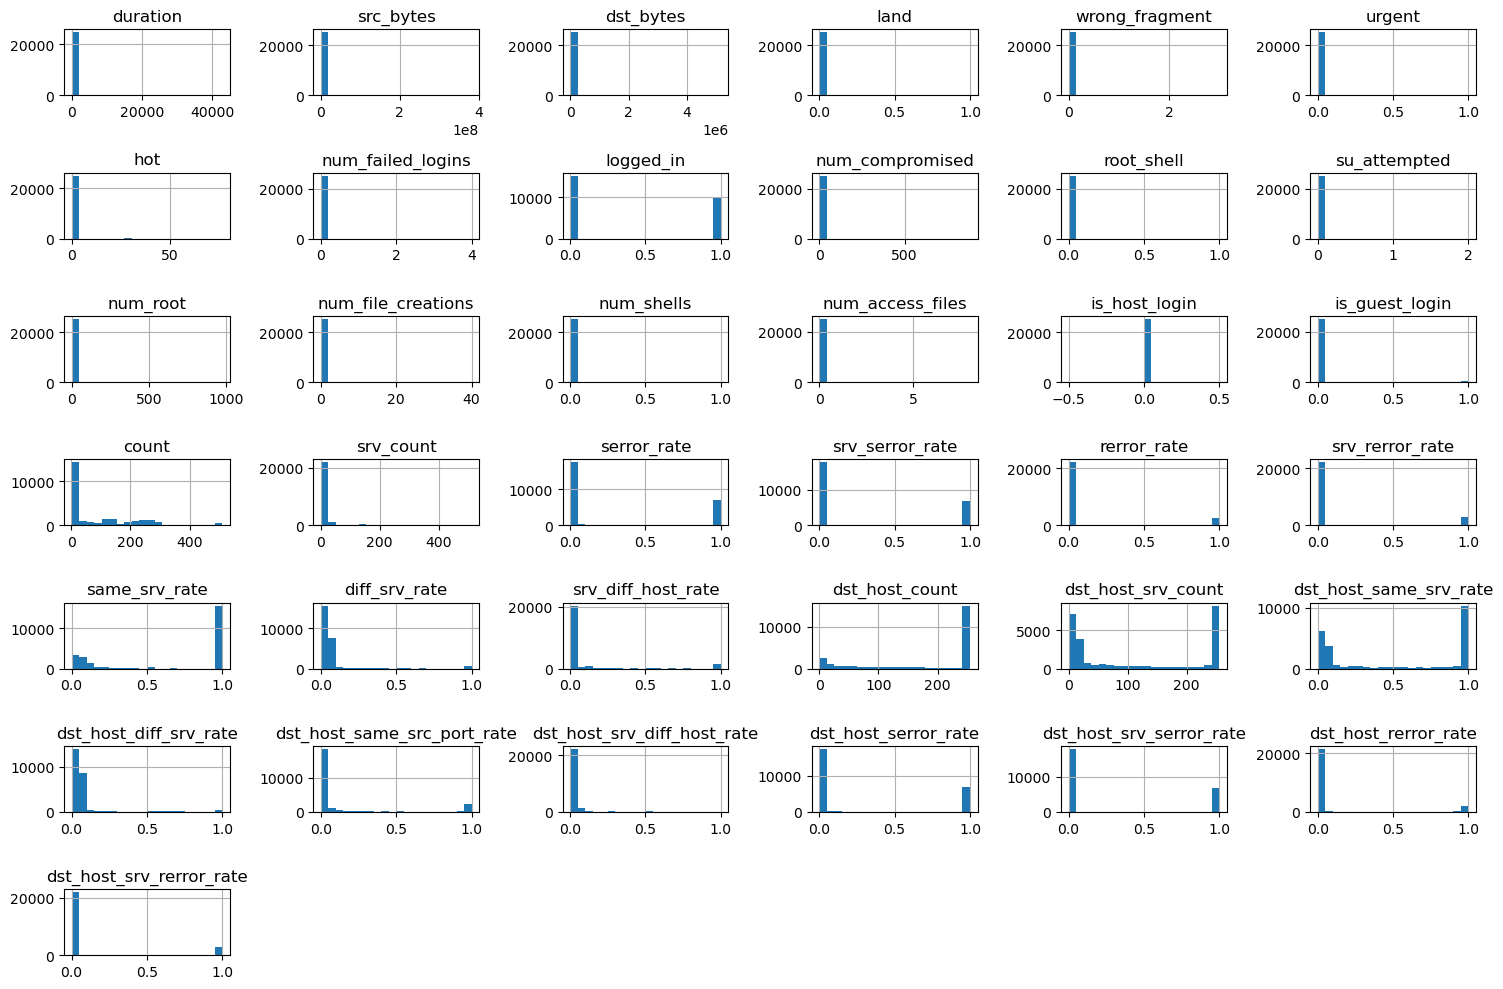

In [16]:
# Numerical Features Distribution
numerical_features = train.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
train[numerical_features].hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

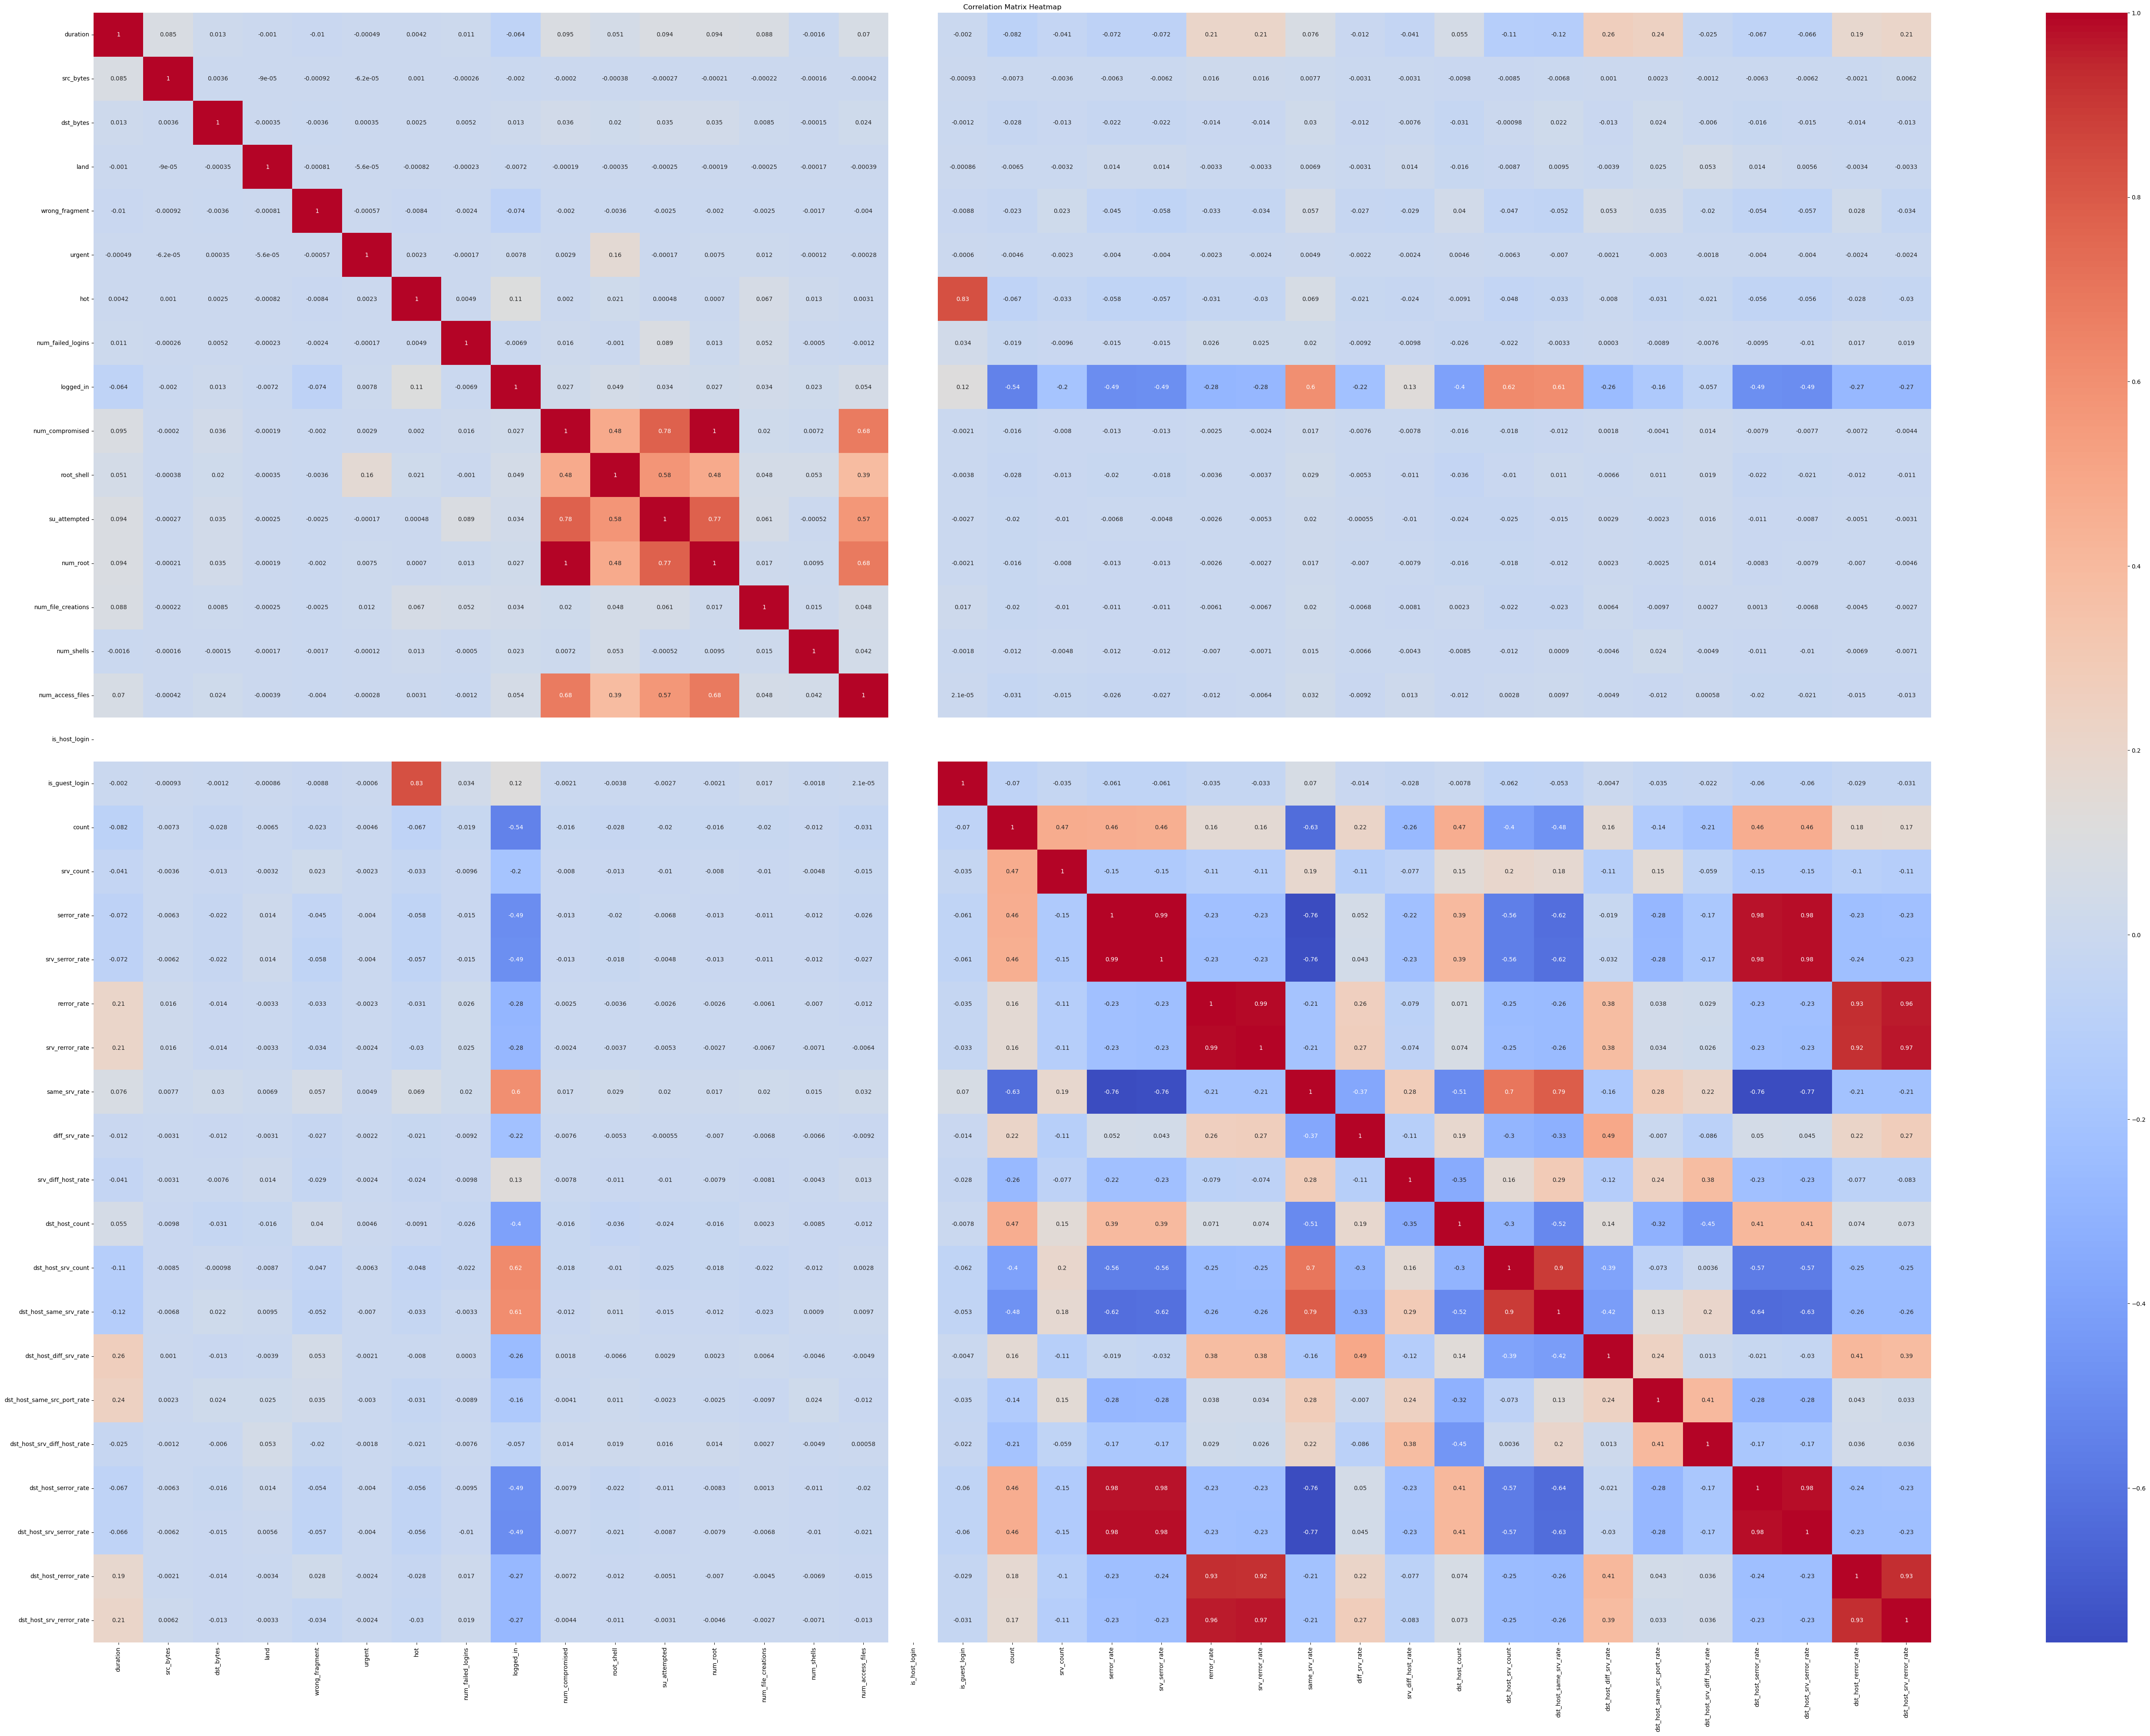

In [17]:
# Correlation Matrix Heatmap
correlation_matrix = train[numerical_features].corr()
plt.figure(figsize=(70, 50))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.show()

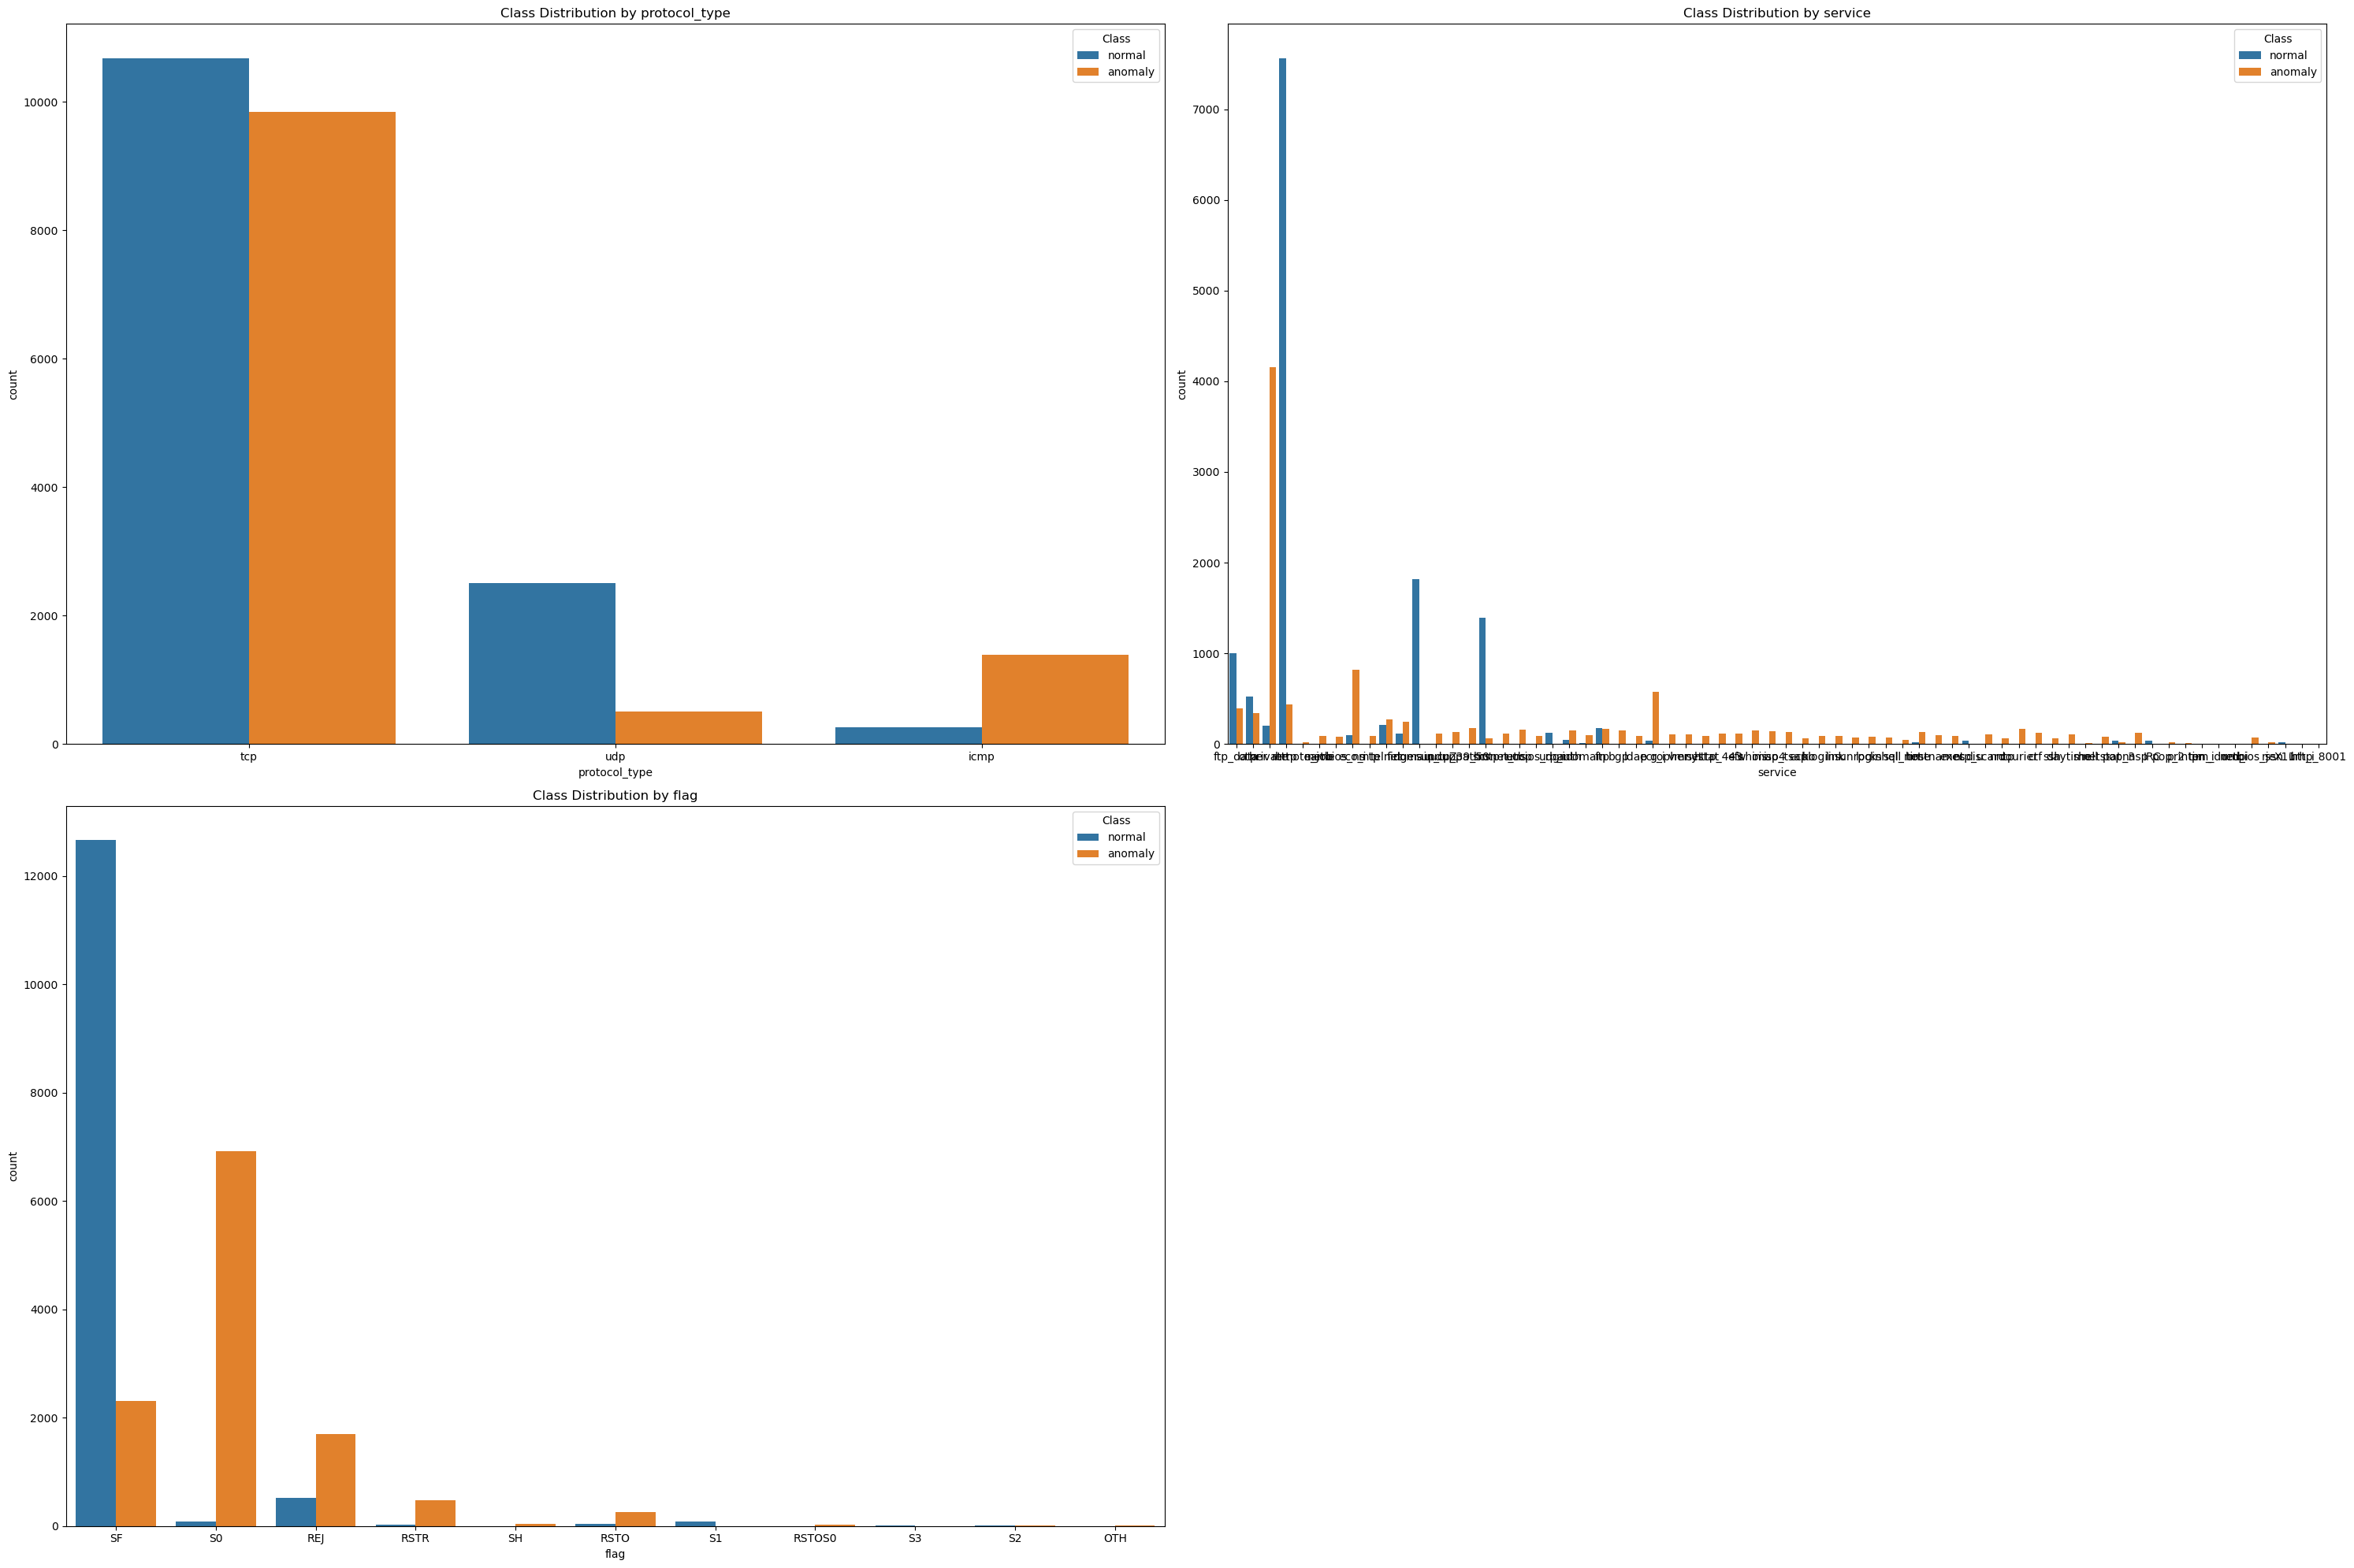

In [18]:
# Class Distribution by Categorical Features
plt.figure(figsize=(30, 20))
for i, f in enumerate(cat_features):
    plt.subplot(2, 2, i + 1)
    sns.countplot(data=train, x=f, hue='class')
    plt.title(f"Class Distribution by {f}")
    plt.legend(title='Class', loc='upper right')
plt.tight_layout()
plt.show()

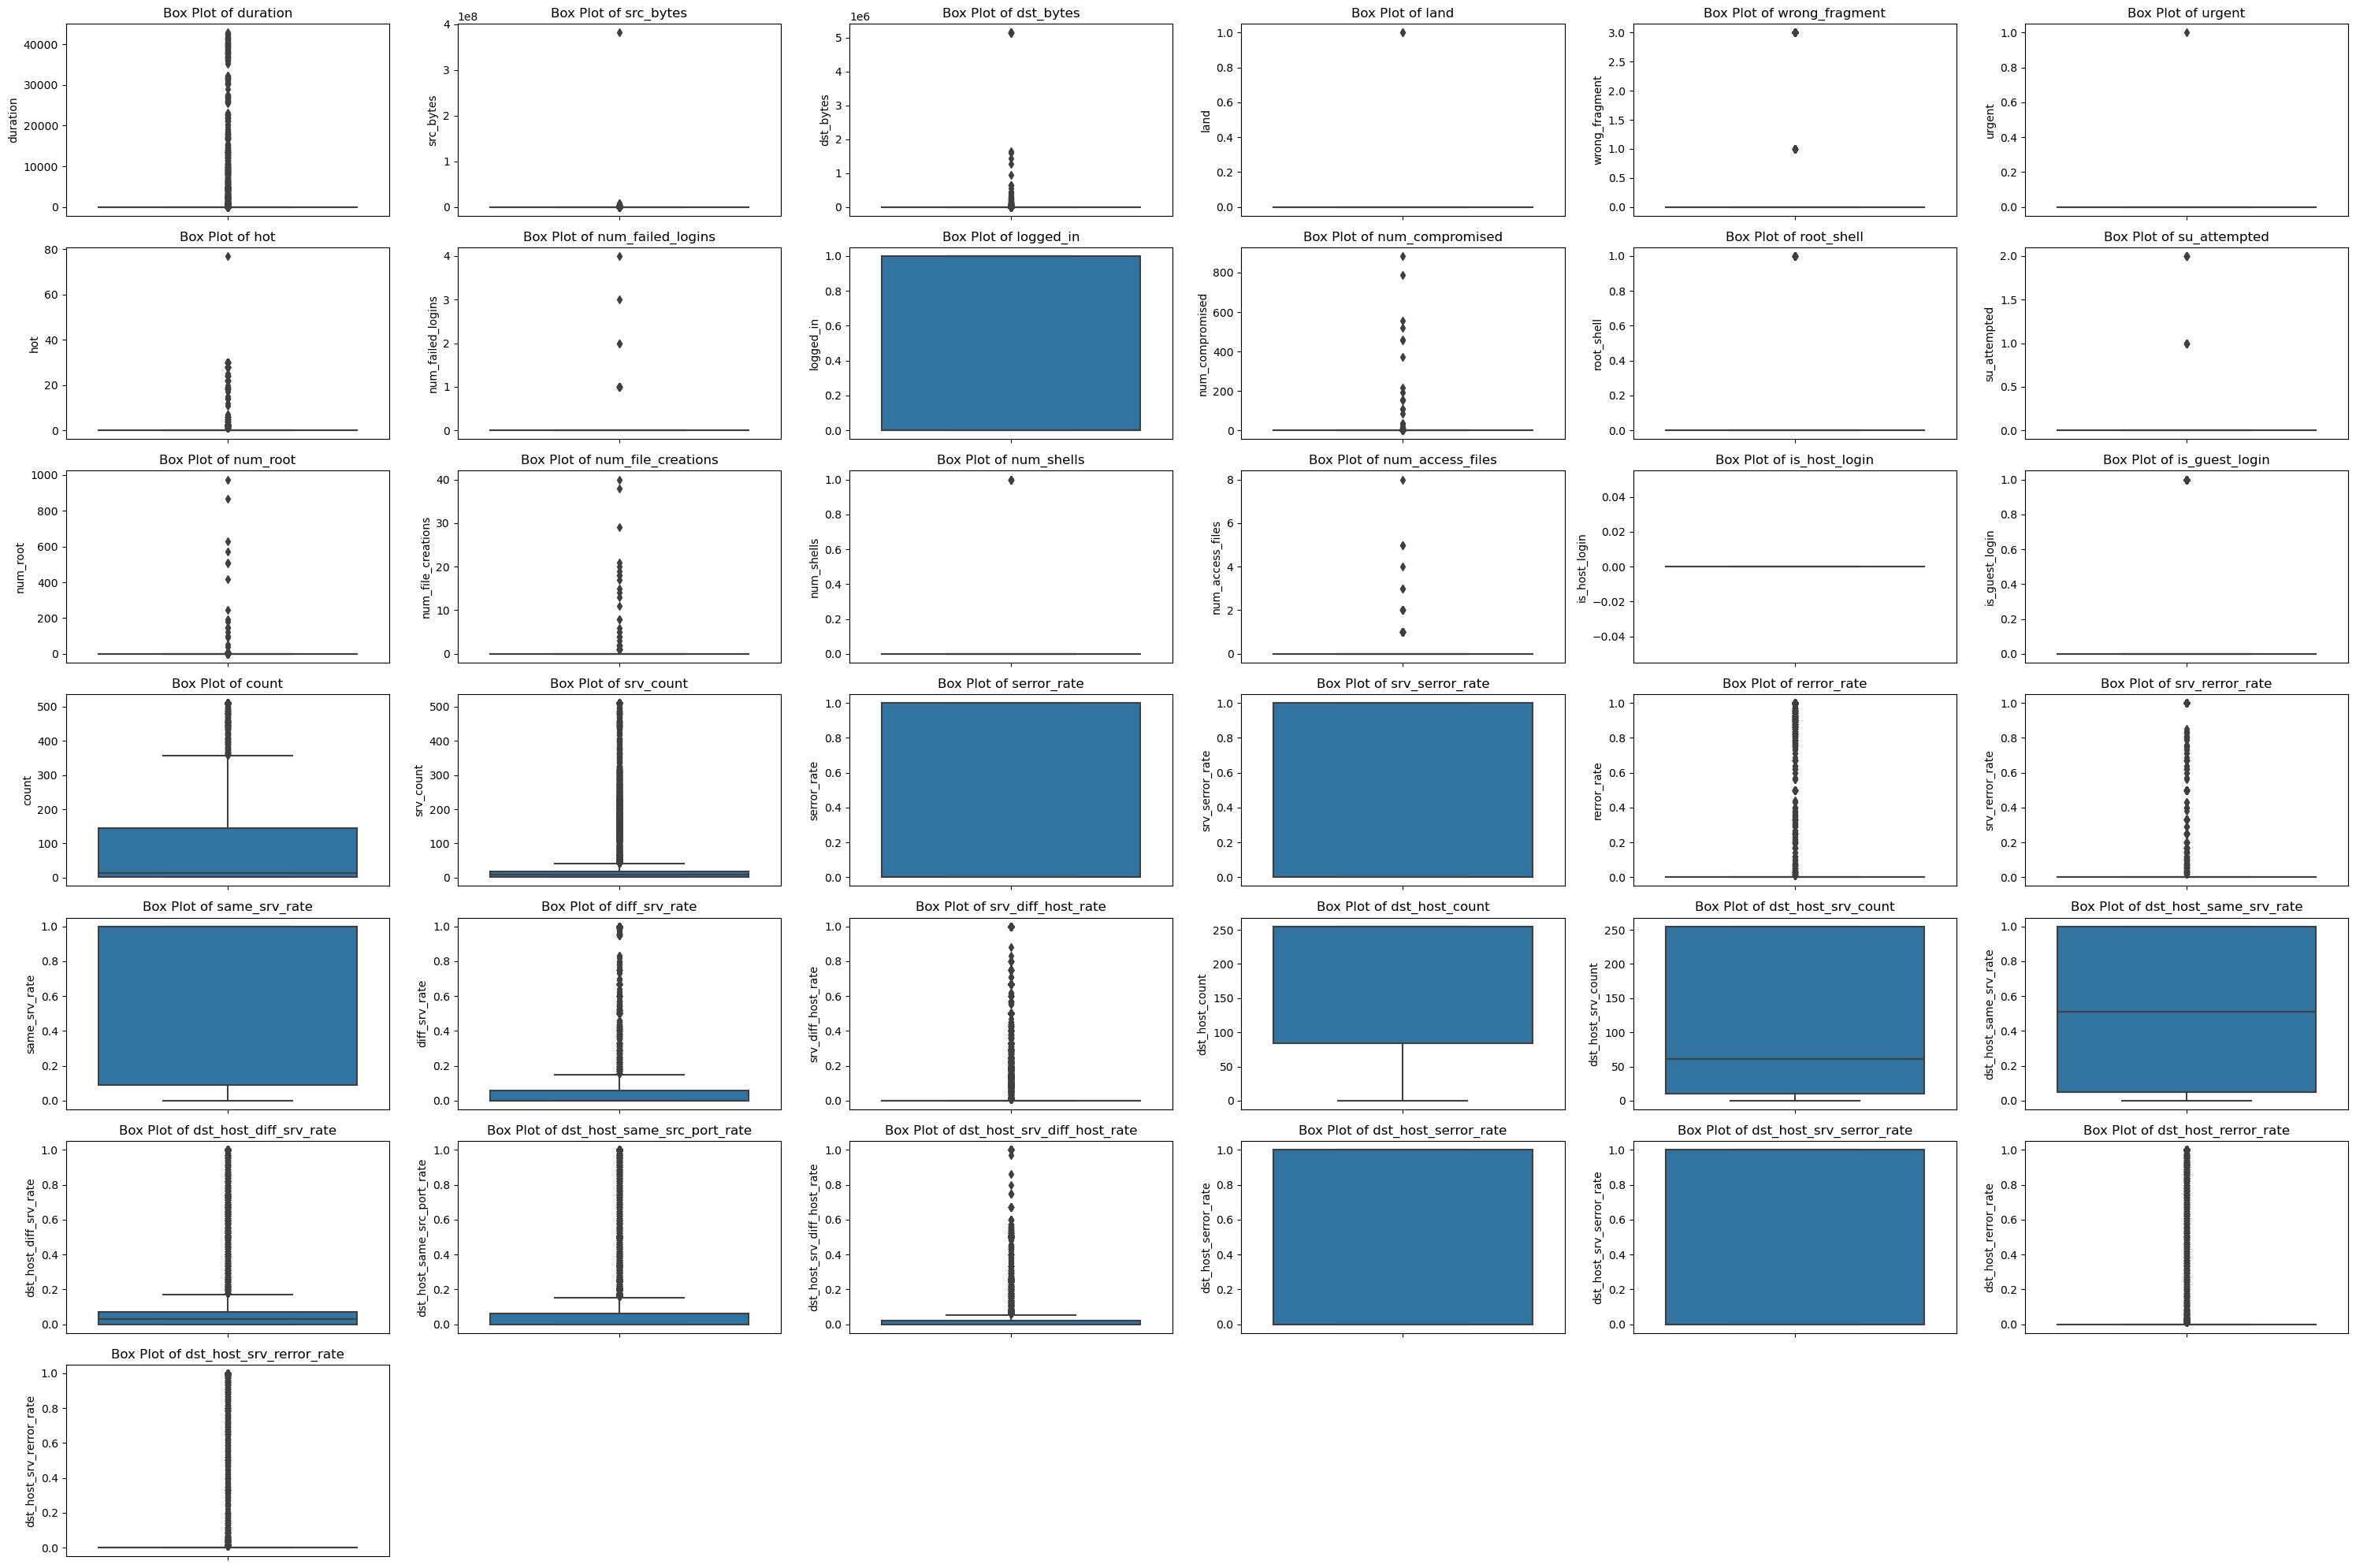

In [19]:
# Outlier Detection - Box Plots
plt.figure(figsize=(30, 20))
num_rows = (len(numerical_features) + 6 - 1) // 6  # Calculate the number of rows

for i, f in enumerate(numerical_features):
    plt.subplot(num_rows, 6, i + 1)  # Use num_rows and 6
    sns.boxplot(data=train, y=f)
    plt.title(f"Box Plot of {f}")

plt.tight_layout()
plt.show()

SCALING NUMERICAL ATTRIBUTES

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

ENCODING CATEGORICAL ATTRIBUTES

In [21]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [22]:
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
train_x.shape

(25192, 40)

In [23]:
test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

FEATURE SELECTION

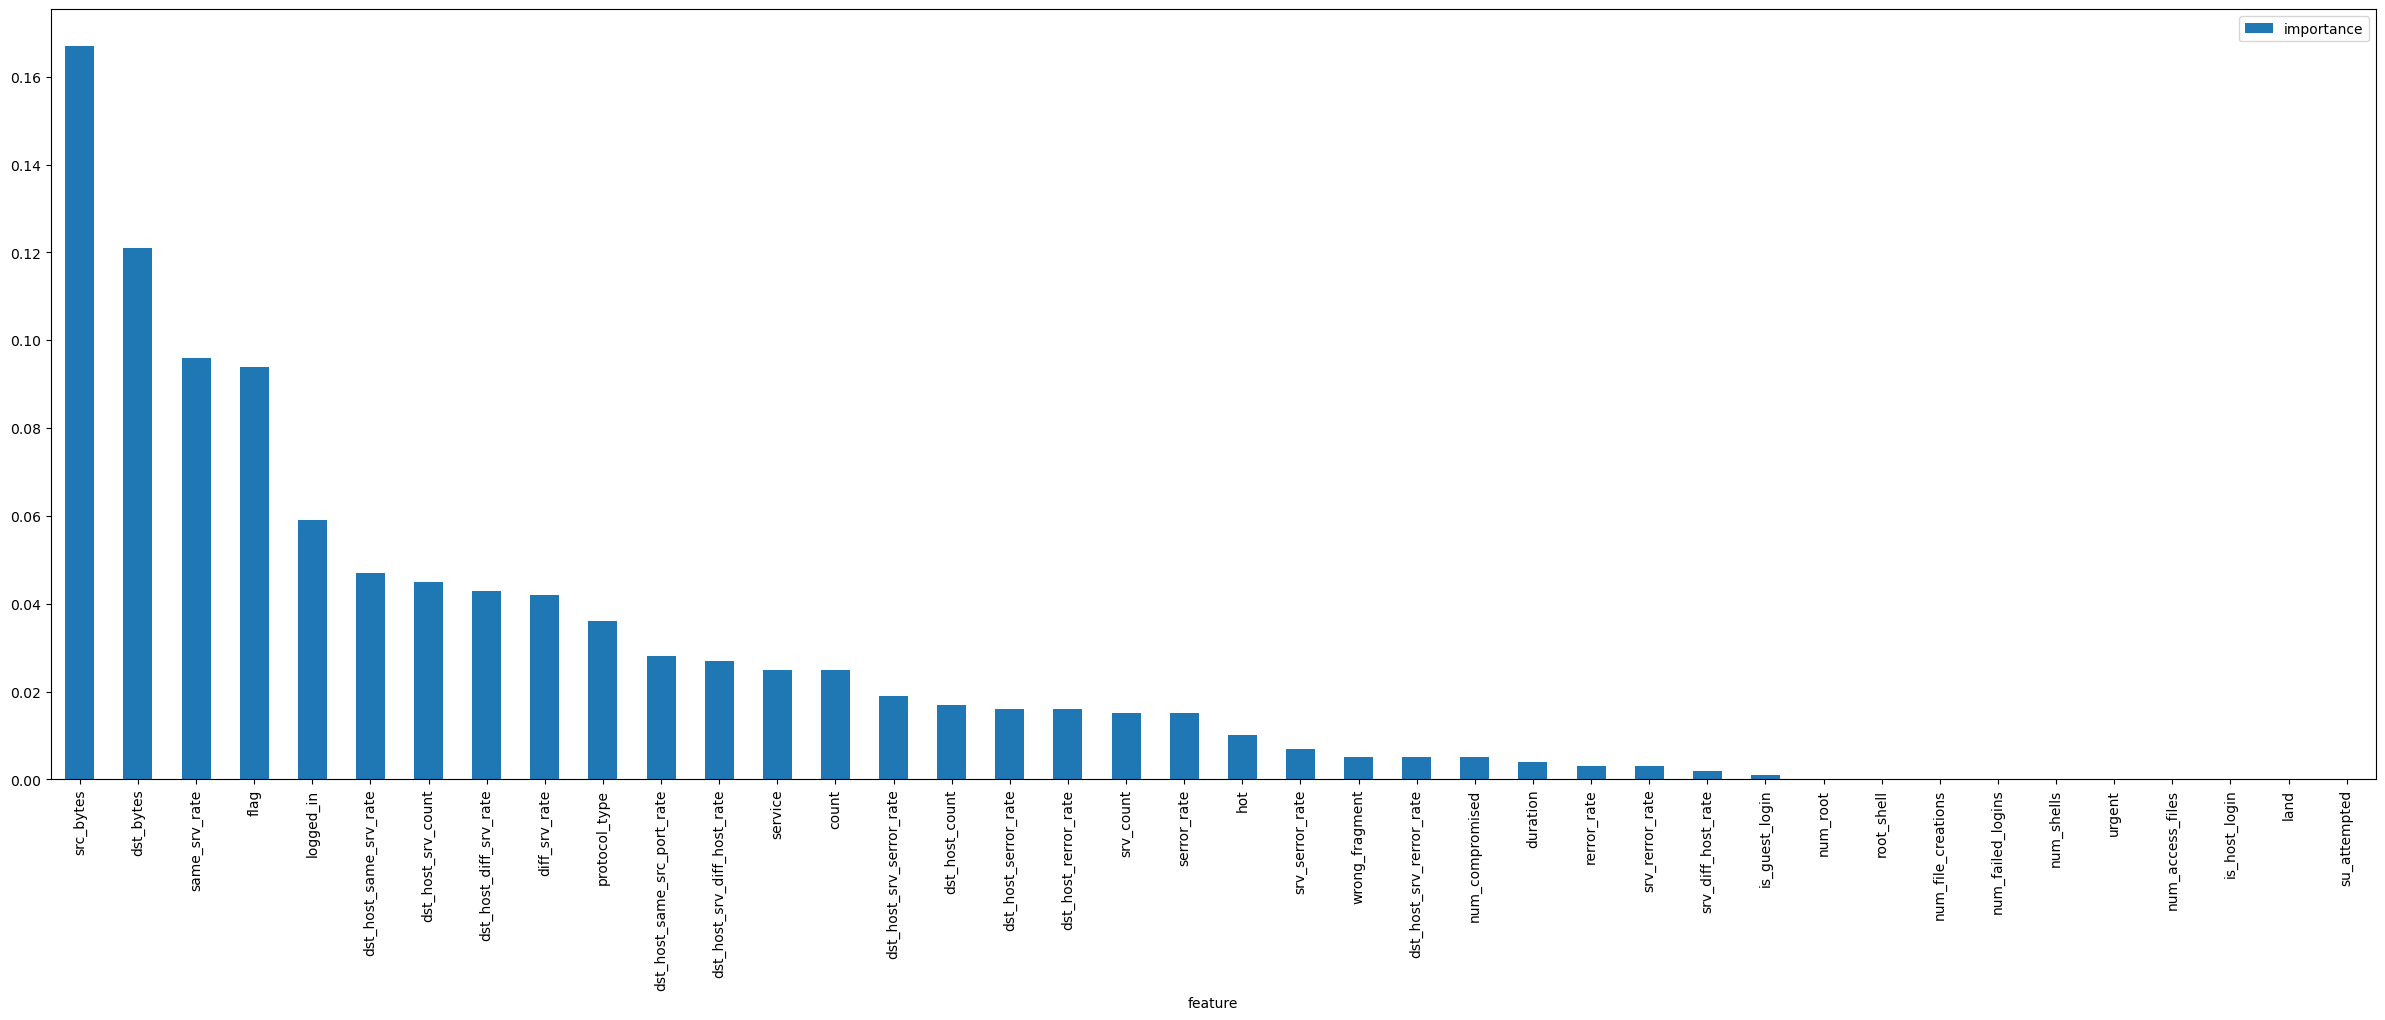

In [24]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (30, 10)
importances.plot.bar();

In [25]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

DATASET PARTITION

In [26]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)

Accuracy: 0.89
Classification Report:
               precision    recall  f1-score   support

     anomaly       0.86      0.91      0.89      3498
      normal       0.92      0.87      0.90      4060

    accuracy                           0.89      7558
   macro avg       0.89      0.89      0.89      7558
weighted avg       0.89      0.89      0.89      7558

Confusion Matrix:
 [[3197  301]
 [ 526 3534]]


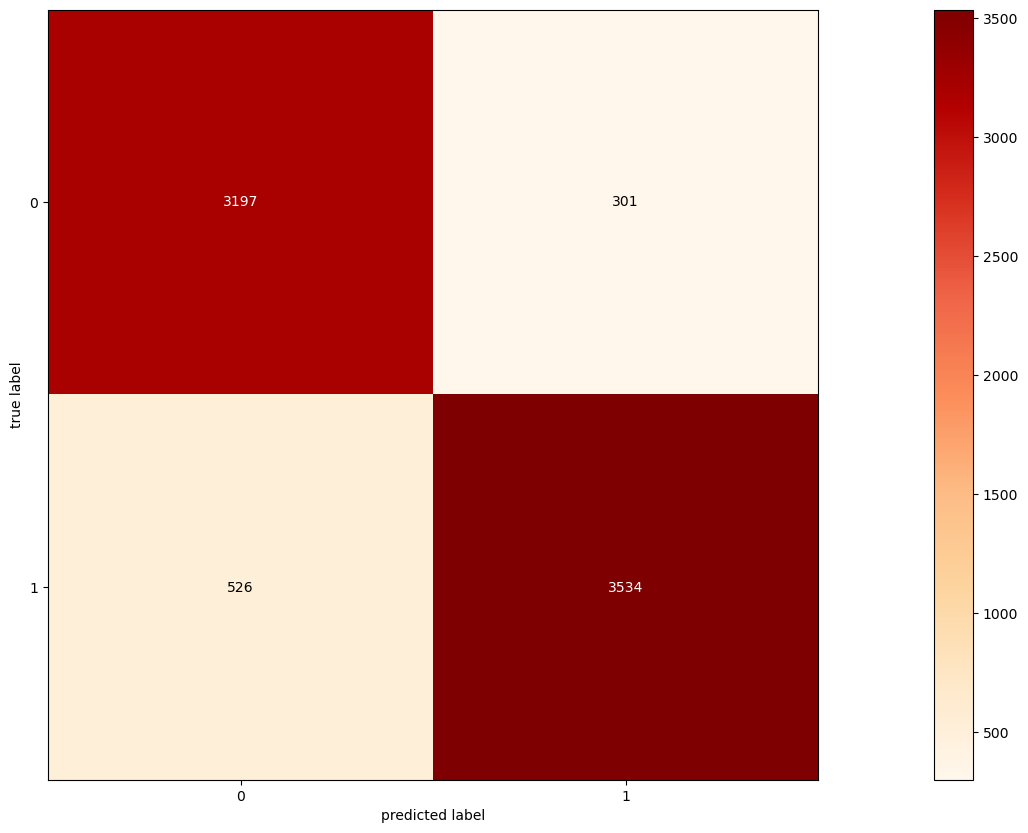

In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Naive Bayes classifier
naive_bayes = GaussianNB()

# Train the classifier on the training data
naive_bayes.fit(X_train, Y_train)

# Predict the target labels for the testing data
predictions = naive_bayes.predict(X_test)

# Evaluate the model's performance
xaccuracy = accuracy_score(Y_test, predictions)
report = classification_report(Y_test, predictions)

print(f"Accuracy: {xaccuracy:.2f}")
print("Classification Report:\n", report)
cf = confusion_matrix(Y_test, predictions)
print("Confusion Matrix:\n", cf)
binary1 =cf
ax = plot_confusion_matrix(conf_mat=binary1,colorbar=True,cmap='OrRd',fontcolor_threshold=0.4)
plt.show()

Accuracy: 0.96
Classification Report:
               precision    recall  f1-score   support

     anomaly       0.96      0.94      0.95      3498
      normal       0.95      0.97      0.96      4060

    accuracy                           0.96      7558
   macro avg       0.96      0.95      0.95      7558
weighted avg       0.96      0.96      0.95      7558

Confusion Matrix:
 [[3295  203]
 [ 137 3923]]


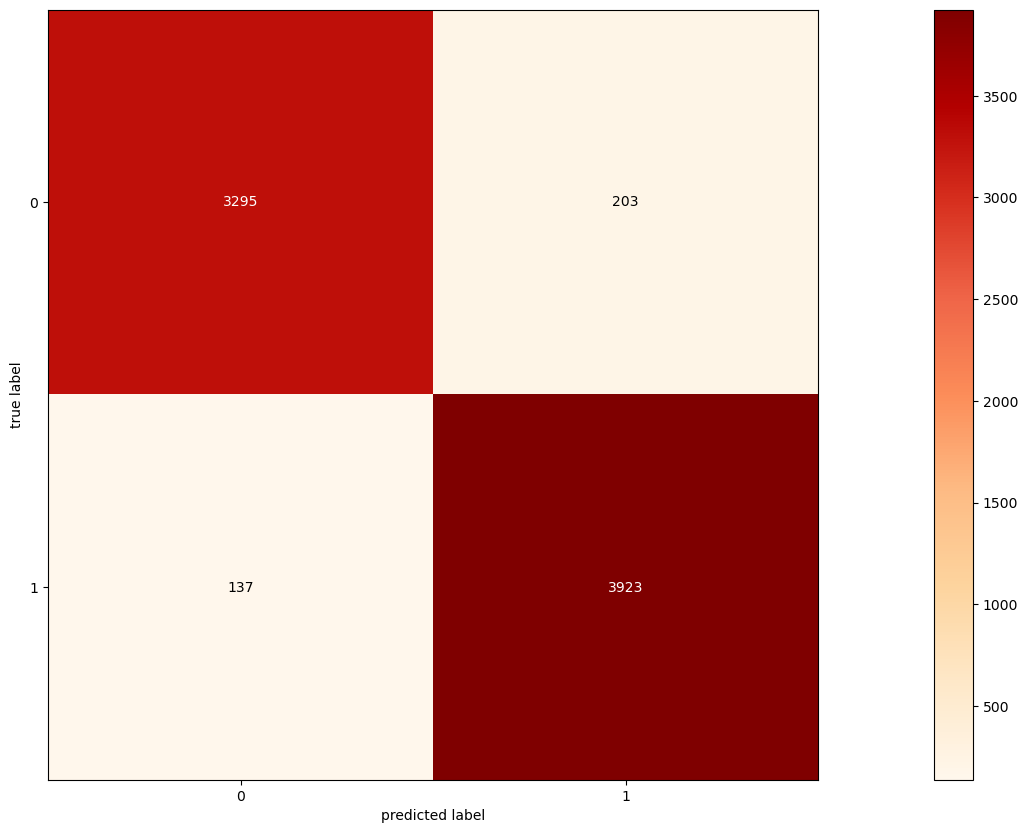

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Step 1: Import the Required Library

# Step 2: Instantiate the Logistic Regression Model
logreg = LogisticRegression()

# Step 3: Fit the Model to the Data
logreg.fit(X_train, Y_train)

# Step 4: Predictions and Evaluation
y_pred = logreg.predict(X_test)

# Calculate accuracy
yaccuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {yaccuracy:.2f}")

# Generate a classification report
print("Classification Report:\n", classification_report(Y_test, y_pred))

# Generate a confusion matrix
cf = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:\n", cf)
binary1 =cf
ax = plot_confusion_matrix(conf_mat=binary1,colorbar=True,cmap='OrRd',fontcolor_threshold=0.4)
plt.show()

Accuracy: 0.9916644614977508
Classification Report:
               precision    recall  f1-score   support

     anomaly       0.99      0.99      0.99      3498
      normal       0.99      0.99      0.99      4060

    accuracy                           0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558

Confusion Matrix:
 [[3458   40]
 [  23 4037]]


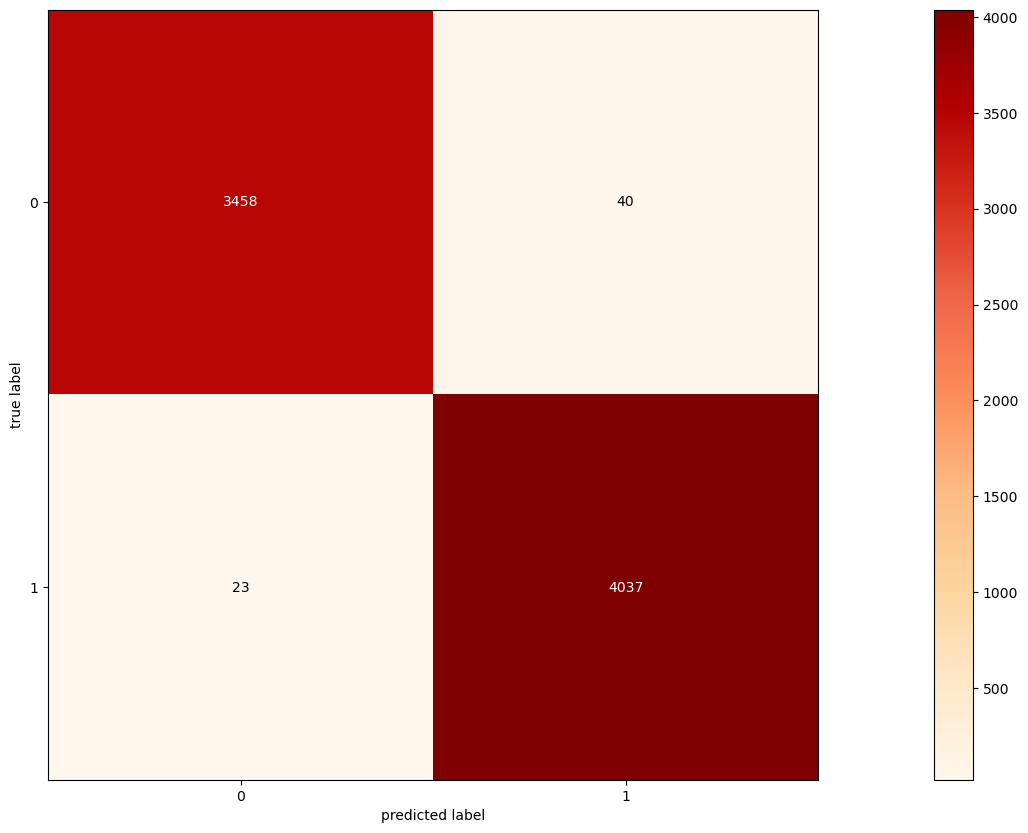

In [29]:
from sklearn.neighbors import KNeighborsClassifier

# Create k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
# Train k-NN classifier
knn_classifier.fit(X_train, Y_train)

# Predict on test data
knn_predictions = knn_classifier.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
zaccuracy = accuracy_score(Y_test, knn_predictions)
print("Accuracy:", zaccuracy)

# Print classification report
print("Classification Report:\n", classification_report(Y_test, knn_predictions))

# Print confusion matrix
cf= confusion_matrix(Y_test, knn_predictions)
print("Confusion Matrix:\n", cf)
binary1 =cf
ax = plot_confusion_matrix(conf_mat=binary1,colorbar=True,cmap='OrRd',fontcolor_threshold=0.4)
plt.show()


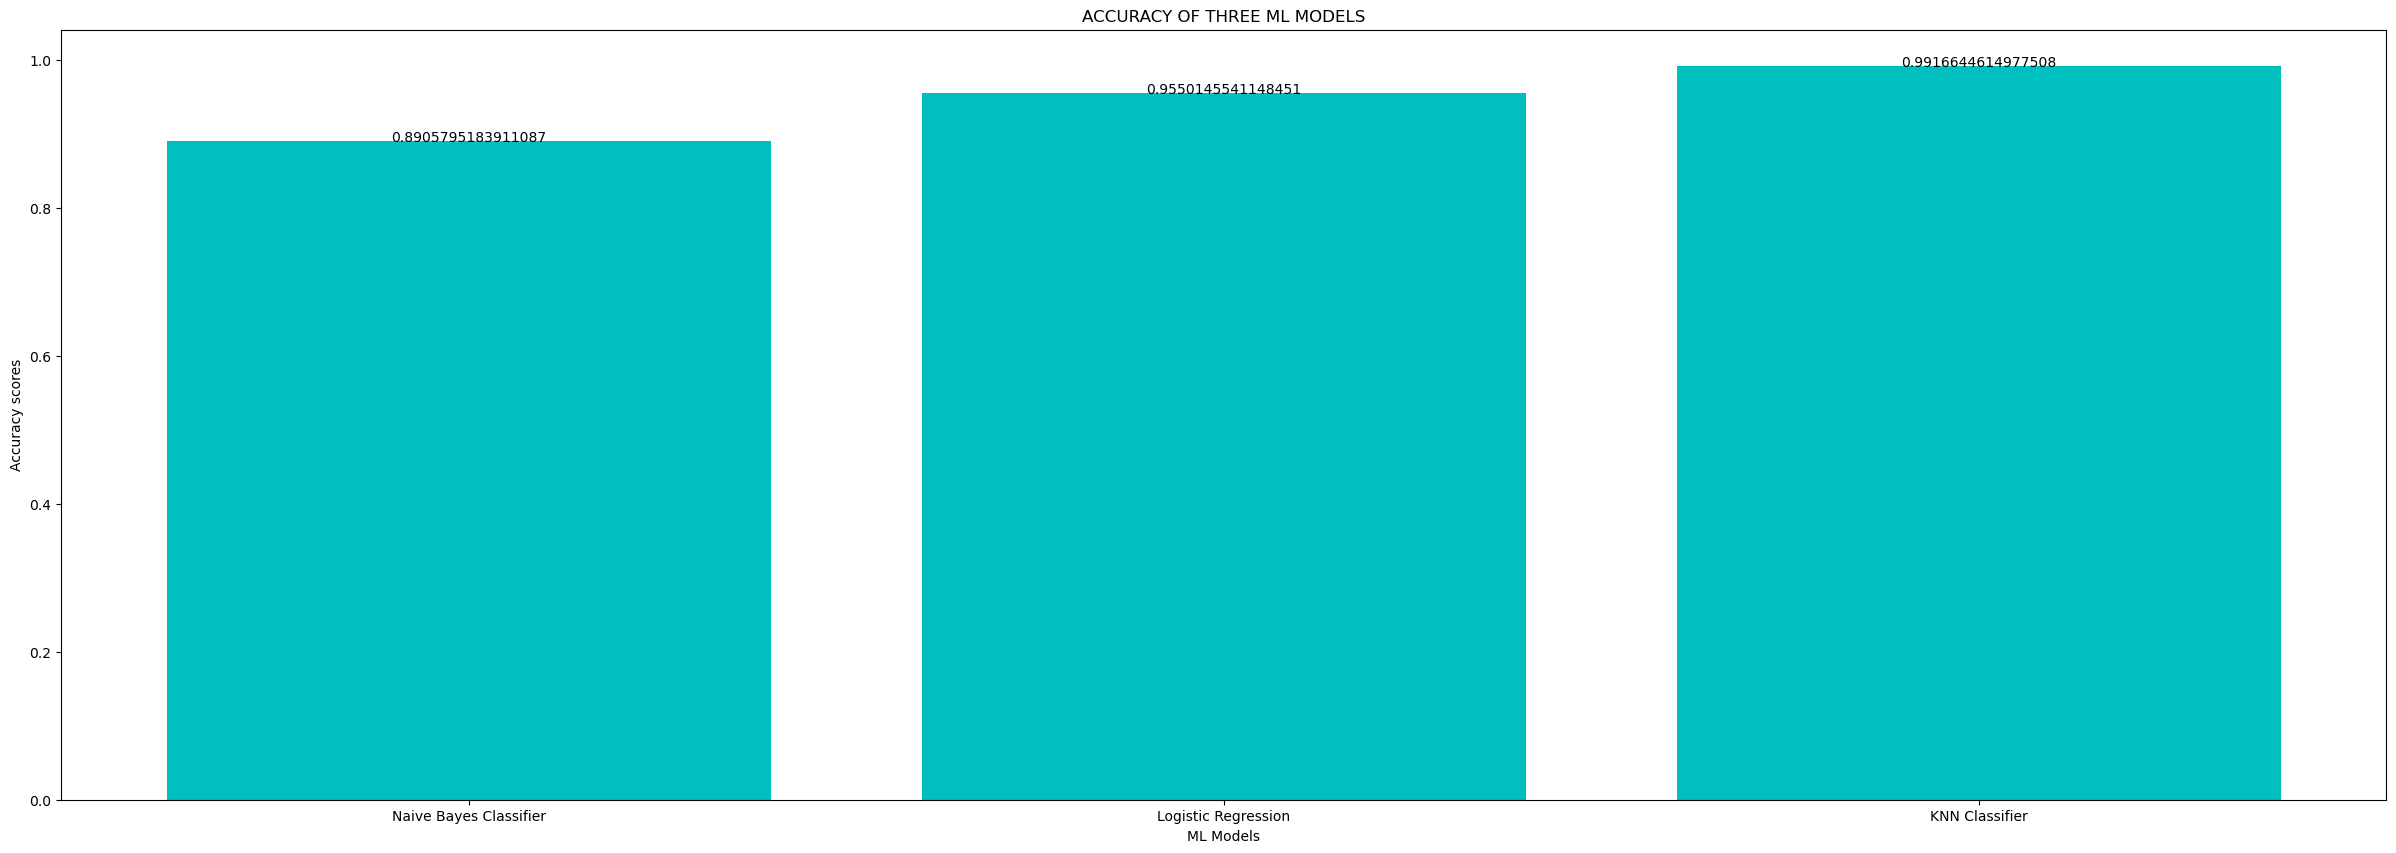

In [30]:

x=['Naive Bayes Classifier','Logistic Regression','KNN Classifier']
y=[xaccuracy,yaccuracy,zaccuracy]

plt.bar(x,y,color='c')
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha = 'center')
plt.title("ACCURACY OF THREE ML MODELS")
plt.ylabel("Accuracy scores")
plt.xlabel("ML Models")
plt.show()